In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [3]:
import pandas as pd
import configs

In [4]:
import os

In [5]:
import pickle
with open('hp_search/conf_json3/cnn_confs.pkl', 'rb') as f:
    cnn_confs = pickle.load(f)
with open('hp_search/conf_json3/lstm_confs.pkl', 'rb') as f:
    lstm_confs = pickle.load(f)
with open('hp_search/conf_json3/nochar_confs.pkl', 'rb') as f:
    nochar_confs = pickle.load(f)

In [6]:
len(cnn_confs[0]), len(lstm_confs[0]), len(nochar_confs[0])

(24, 23, 21)

In [7]:
models_folder = 'hp_search/models5'
conf_folder = 'hp_search/conf5'
json_folder = 'hp_search/conf_json5'
logs_folder = 'hp_search/logs5'


In [8]:
if not os.path.exists(models_folder):
    os.mkdir(models_folder)
if not os.path.exists(conf_folder):
    os.mkdir(conf_folder)
if not os.path.exists(json_folder):
    os.mkdir(json_folder)
if not os.path.exists(logs_folder):
    os.mkdir(logs_folder)

In [9]:
import json
def create_all_confs(confs, arch_name, ds_name, emb_name, conf_folder, models_folder, json_folder):
    max_digits = len(str(len(confs)))
    full_confs = []
    for i, conf in enumerate(confs):
        fc = configs.create_conf_file(os.path.join(conf_folder, arch_name+f'.{str(i).zfill(max_digits)}.conf'), 
                                 os.path.join(models_folder, arch_name+f'.{str(i).zfill(max_digits)}.model'), 
                                 ds_name, 
                                 conf, 
                                 emb_name)
        full_confs.append(fc)

    for i, fc in enumerate(full_confs):
        with open( os.path.join(json_folder, arch_name+f'.{str(i).zfill(max_digits)}.json'), 'w') as of:
            of.write(json.dumps(fc))

In [10]:
create_all_confs(lstm_confs, 'morph_charlstm', 'gold_morpheme', 'alt_tok_yap_w2v_sg', 
                 conf_folder, models_folder, json_folder)

In [11]:
create_all_confs(cnn_confs, 'morph_charcnn', 'gold_morpheme', 'alt_tok_yap_w2v_sg', 
                 conf_folder, models_folder, json_folder)

## Token

In [12]:
create_all_confs(lstm_confs, 'token_charlstm', 'gold_token_bioes', 'alt_tok_tokenized_w2v_sg', 
                 conf_folder, models_folder, json_folder)

In [13]:
create_all_confs(cnn_confs, 'token_charcnn', 'gold_token_bioes', 'alt_tok_tokenized_w2v_sg', 
                 conf_folder, models_folder, json_folder)

## Token Multi-Tag

In [14]:
create_all_confs(lstm_confs, 'multitok_charlstm', 'gold_token_raw', 'alt_tok_tokenized_w2v_sg', 
                 conf_folder, models_folder, json_folder)

In [15]:
create_all_confs(cnn_confs, 'multitok_charcnn', 'gold_token_raw', 'alt_tok_tokenized_w2v_sg', 
                 conf_folder, models_folder, json_folder)

## NoChar

In [16]:
create_all_confs(nochar_confs, 'morph_nochar', 'gold_morpheme', 'alt_tok_yap_w2v_sg', 
                 conf_folder, models_folder, json_folder)

In [17]:
create_all_confs(nochar_confs, 'token_nochar', 'gold_token_bioes', 'alt_tok_tokenized_w2v_sg', 
                 conf_folder, models_folder, json_folder)

In [18]:
create_all_confs(nochar_confs, 'multitok_nochar', 'gold_token_raw', 'alt_tok_tokenized_w2v_sg', 
                 conf_folder, models_folder, json_folder)

# RUNNING ON NLP08, NLP10, NLP11, NLP13, NLP05, NLP14
cd NCRFpp/  
conda activate ncrf_gpu  
python run4_hp_search.py 3 token_charlstm.2  


## Check results

In [7]:
import pickle
with open('hp_search/conf_json3/cnn_confs.pkl', 'rb') as f:
    cnn_confs = pickle.load(f)
with open('hp_search/conf_json3/lstm_confs.pkl', 'rb') as f:
    lstm_confs = pickle.load(f)
with open('hp_search/conf_json3/nochar_confs.pkl', 'rb') as f:
    nochar_confs = pickle.load(f)

In [19]:
len(cnn_confs[0]), len(lstm_confs[0]), len(nochar_confs[0])

(24, 23, 21)

In [127]:
import re
import os
DEV_RES_LINE = re.compile('Dev: .*; acc: (?P<acc>[^,]+)(?:, p: (?P<p>[^,]+), r: (?P<r>[^,]+), f: (?P<f>[-\d\.]+))?')
#Dev: time: 0.94s speed: 536.09st/s; acc: 0.9043
#Dev: time: 3.42s, speed: 146.59st/s; acc: 0.9546, p: 0.7577, r: 0.6393, f: 0.6935

mtimes = []
res = []
archs = []
for f in os.scandir('hp_search/logs5'):
    if f.name.startswith('.ipy'):
        continue
    mtimes.append(os.path.getmtime(f.path))
    arch = f.name.split('.')[0]
    archs.append(arch)
    unit = arch.split('_')[0]
    conf_num = f.name.split('.')[1]
    if 'cnn' in arch:
        matching_conf = cnn_confs[int(conf_num)] 
    elif 'lstm' in arch: 
        matching_conf = lstm_confs[int(conf_num)]
    elif 'nochar' in arch:
        matching_conf = nochar_confs[int(conf_num)]
    params = { 'arch': arch, 'unit': unit, 'conf_num': conf_num}
    params.update(matching_conf)
    with open(f.path, 'r') as fp:
        i= 0
        for line in fp:
            m = DEV_RES_LINE.match(line)
            if m:
                r = m.groupdict().copy()
                for k, v in r.items():
                    if v is not None:
                        r[k] = float(v)
                r.update(params)
                r['epoch'] = i
                i+=1
                res.append(r)

rdf = pd.DataFrame(res)

rdf['model_file_name'] = rdf.arch + '.' + rdf.conf_num +'.model.' + rdf.epoch.astype(str) + '.model'
rdf['dset_file_name'] =  rdf.arch + '.' + rdf.conf_num +'.model.dset'
rdf['char_seq_feature'] = rdf.char_seq_feature.fillna('NoChar')

rdf['relevant_score'] = rdf.f.fillna(rdf.acc)

erdf = rdf[(rdf.groupby(['conf_num', 'arch']).relevant_score.transform(max)==rdf.relevant_score) ]
erdf = erdf[(erdf.groupby(['conf_num', 'arch']).epoch.transform(min)==erdf.epoch) ]

In [128]:
erdf.shape

(87, 35)

In [129]:
erdf.groupby('arch').size()

arch
morph_charcnn        15
morph_charlstm        6
morph_nochar          4
multitok_charcnn     20
multitok_charlstm     7
multitok_nochar       4
token_charcnn        20
token_charlstm        7
token_nochar          4
dtype: int64

In [130]:
print ('Mean time per run:', round((max(mtimes) - min(mtimes) )/ len(mtimes) / 60, 2), 'minutes')

Mean time per run: 19.04 minutes


In [131]:
import numpy as np 
def perc(n):
    def perc_(x):
        return np.percentile(x, n)
    perc_.__name__ = 'perc_%s' % n
    return perc_

erdf.groupby(['unit', 'char_seq_feature']).f.agg(['max', 'min', 'mean', 'std', 'median', perc(95)])

max     min      mean       std   median  \
unit     char_seq_feature                                                
morph    CNN               0.7093  0.6285  0.679633  0.023619  0.68740   
         LSTM              0.6988  0.6846  0.693767  0.006033  0.69590   
         NoChar            0.6843  0.6736  0.678600  0.005170  0.67825   
multitok CNN                  NaN     NaN       NaN       NaN      NaN   
         LSTM                 NaN     NaN       NaN       NaN      NaN   
         NoChar               NaN     NaN       NaN       NaN      NaN   
token    CNN               0.6539  0.6293  0.641950  0.007059  0.64265   
         LSTM              0.6464  0.6300  0.638443  0.007544  0.63600   
         NoChar            0.6227  0.6124  0.618375  0.004582  0.61920   

                            perc_95  
unit     char_seq_feature            
morph    CNN               0.706360  
         LSTM              0.698775  
         NoChar            0.683895  
multitok CNN                    NaN  
         LSTM                   NaN  
         NoChar                 NaN  
token    CNN               0.651905  
         LSTM              0.646370  
         NoChar            0.622460

## Evaluate files (Mention Evaluation)

In [132]:
import sys
sys.path.append('../NER')

In [133]:
import ne_evaluate_mentions as nem

## Create configs for decoding

In [134]:
model_folder = 'hp_search/models5'
output_folder = 'hp_search/decode_output5'
conf_folder = 'hp_search/decode_conf5'

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

if not os.path.exists(conf_folder):
    os.mkdir(conf_folder)
    
decode_sets = {
    'morph': {
        'morph_dev_gold': '../NER/data/for_ncrf/morph_gold_dev.bmes',
        'morph_dev_yap': '../NER/data/for_ncrf/morph_yap_dev_dummy_o.bmes',
        'morph_test_gold': '../NER/data/for_ncrf/morph_gold_test.bmes',
        'morph_test_yap': '../NER/data/for_ncrf/morph_yap_test_dummy_o.bmes',
    },
    'token': {
        'token_dev': '../NER/data/for_ncrf/token_gold_dev_fix.bmes',
        'token_test': '../NER/data/for_ncrf/token_gold_test_fix.bmes',
    },
    'multitok': {
        'token_dev': '../NER/data/for_ncrf/token_gold_dev_concat.bmes',
        'token_test': '../NER/data/for_ncrf/token_gold_test_concat.bmes',
    }
}

params = { 'status': 'decode' }

for i, row in erdf.iterrows():
    unit = row['arch'].split('_')[0]
    for name, set_path in decode_sets[unit].items():
        row_par = params.copy()
        row_par['load_model_dir'] = os.path.join(model_folder, row['model_file_name'])
        row_par['dset_dir'] = os.path.join(model_folder, row['dset_file_name'])
        row_par['decode_dir'] = os.path.join(output_folder, name+'.'+row['arch']+'.'+row['conf_num']+'.bmes')
        row_par['raw_dir'] = set_path
        
        conf_path = os.path.join(conf_folder, name+'.'+row['arch']+'.'+row['conf_num']+'.decode.conf')
        if not os.path.exists(conf_path):
            with open(conf_path, 'w', encoding='utf8') as of:
                for k, v in row_par.items():
                    of.write(k+'='+str(v)+'\n')        
 

## Evaluate decoded folder

In [91]:
scores = {}

In [121]:
if os.path.exists('hp_search/scores5.pkl'):
    scores = pickle.load(open('hp_search/scores5.pkl', 'rb'))

In [135]:
for file in os.scandir(output_folder):
    if file.name=='.ipynb_checkpoints':
        continue
    gold_name, arch, conf_num = file.name.split('.')[:3]
    if (gold_name, arch, conf_num) not in scores:
        _, charsf = arch.split('_')
        if len(gold_name.split('_'))>2:
            unit, pred_set, _ = gold_name.split('_')
            gold_path = decode_sets[unit][unit+'_'+pred_set+'_gold']
        else:
            unit, pred_set = gold_name.split('_')
            gold_path = decode_sets[unit][unit+'_'+pred_set]
        p, r, f = nem.evaluate_files(gold_path, file)
        scores[(gold_name, arch, conf_num)] = (p, r, f)
        
pickle.dump(scores, open('hp_search/scores5.pkl', 'wb'))

In [136]:
score_tups = [(*k, *v) for k,v in scores.items()]

In [137]:
mev = pd.DataFrame(score_tups, columns=('gold_name', 'arch', 'conf_num', 'p', 'r', 'f'))
mev[mev.gold_name.str.contains('dev')].groupby(['gold_name', 'arch']).f.agg(['max', 'min', 'mean', 'std', 'median', perc(95)])

max       min      mean       std  \
gold_name      arch                                                        
morph_dev_gold morph_charcnn      0.710911  0.629108  0.680170  0.024000   
               morph_charlstm     0.701124  0.686722  0.695820  0.005994   
               morph_nochar       0.686636  0.675926  0.680899  0.004890   
morph_dev_yap  morph_charcnn      0.637911  0.574972  0.615397  0.018074   
               morph_charlstm     0.632420  0.613779  0.624384  0.006547   
               morph_nochar       0.616628  0.611958  0.614488  0.002482   
token_dev      multitok_charcnn   0.645949  0.609813  0.634335  0.009401   
               multitok_charlstm  0.637053  0.622472  0.630444  0.004902   
               multitok_nochar    0.626374  0.600432  0.612164  0.013077   
               token_charcnn      0.654628  0.630072  0.642242  0.006987   
               token_charlstm     0.647123  0.631813  0.639391  0.007007   
               token_nochar       0.624130  0.615385  0.620405  0.003700   

                                    median   perc_95  
gold_name      arch                                   
morph_dev_gold morph_charcnn      0.688488  0.706365  
               morph_charlstm     0.697496  0.701095  
               morph_nochar       0.680518  0.686112  
morph_dev_yap  morph_charcnn      0.623583  0.630275  
               morph_charlstm     0.624516  0.631670  
               morph_nochar       0.614683  0.616625  
token_dev      multitok_charcnn   0.632344  0.645883  
               multitok_charlstm  0.631236  0.636069  
               multitok_nochar    0.610925  0.625441  
               token_charcnn      0.643716  0.651238  
               token_charlstm     0.635955  0.647104  
               token_nochar       0.621053  0.623782

In [138]:
mev['pred_set'] = mev.gold_name.apply(lambda x: '_'.join(x.split('_')[1:]).replace('_yap', ''))

In [139]:
mev = mev.set_index(['arch', 'conf_num', 'pred_set'])[['p', 'r', 'f']].unstack()
mev.columns = ['_'.join(col).rstrip('_') for col in mev.columns.values]
mev.head()

p_dev  p_dev_gold    p_test  p_test_gold     r_dev  \
arch          conf_num                                                          
morph_charcnn 00        0.558233    0.628514  0.534335     0.637339  0.695000   
              01        0.544177    0.624498  0.536481     0.636266  0.734417   
              02        0.550201    0.614458  0.535408     0.638412  0.726790   
              03        0.546185    0.614458  0.528970     0.624464  0.719577   
              04        0.538153    0.600402  0.512876     0.615880  0.744444   

                        r_dev_gold    r_test  r_test_gold     f_dev  \
arch          conf_num                                                
morph_charcnn 00          0.769042  0.654402     0.734240  0.619154   
              01          0.807792  0.695410     0.778215  0.625144   
              02          0.794805  0.673414     0.755076  0.626286   
              03          0.780612  0.659091     0.734848  0.621005   
              04          0.808108  0.683834     0.755263  0.624709   

                        f_dev_gold    f_test  f_test_gold  
arch          conf_num                                     
morph_charcnn 00          0.691713  0.588305     0.682366  
              01          0.704417  0.605694     0.700118  
              02          0.693092  0.596533     0.691860  
              03          0.687640  0.586905     0.675174  
              04          0.688940  0.586143     0.678487

In [140]:
erdf = erdf.merge(mev.reset_index(), on=['arch', 'conf_num'])

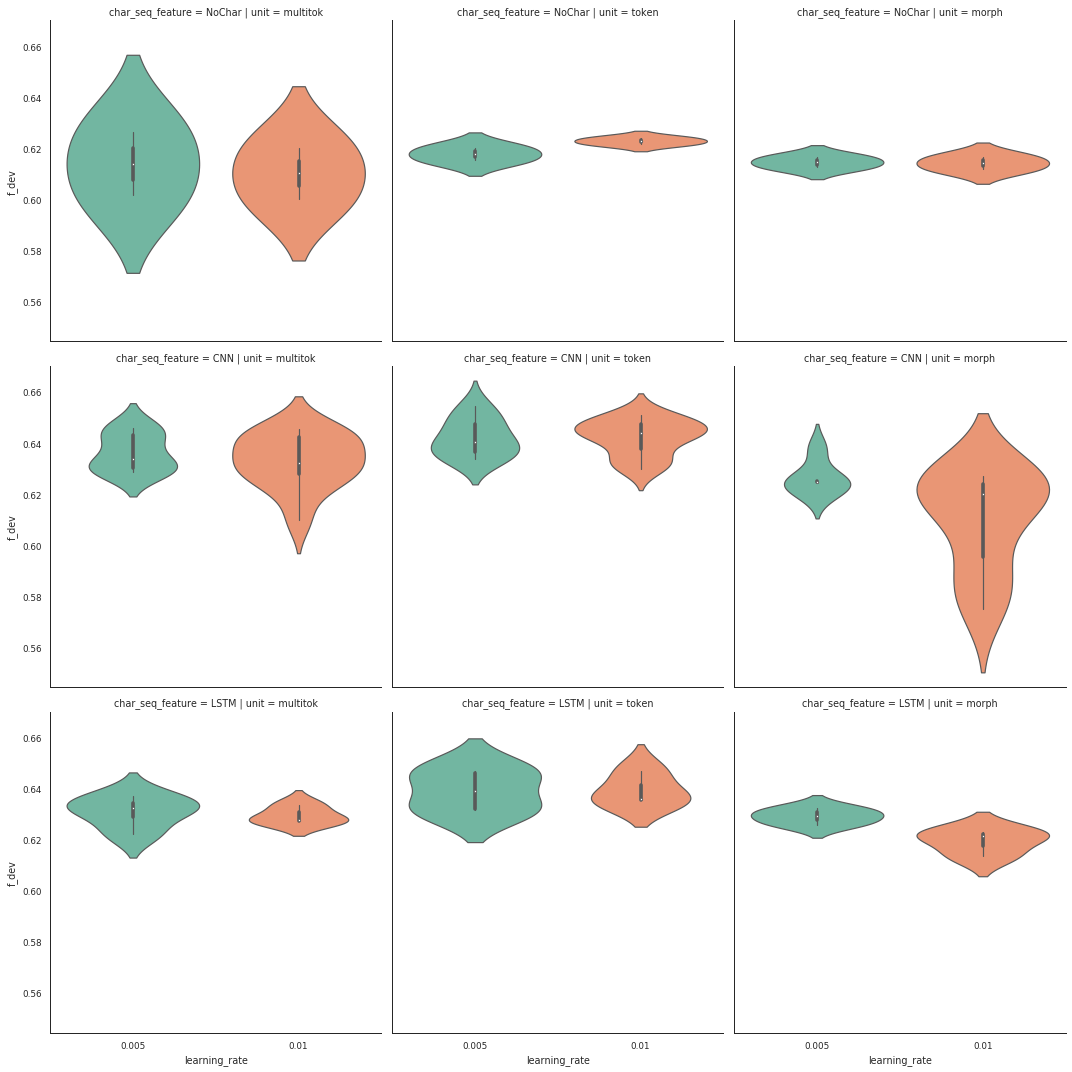

In [141]:
sns.catplot(kind='violin', row='char_seq_feature', col='unit', 
            x="learning_rate", y="f_dev", #hue='batch_size',
                data=erdf, palette="Set2",
                scale="count", inner="box", scale_hue=True)

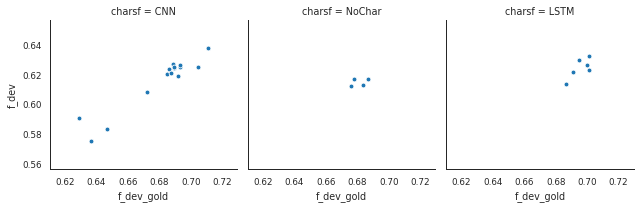

In [142]:
>>> g = sns.FacetGrid(erdf[erdf.unit=='morph'].rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col='charsf')
>>> g = g.map(plt.scatter, "f_dev_gold", "f_dev", edgecolor="w")

In [143]:
cols = ['f', 'p', 'r', 'char_seq_feature', 'lstm_layer', 'batch_size', 
        'learning_rate', 'char_hidden_dim', 'char_kernel_size',
        'hidden_dim', 'dropout', 'epoch']

In [144]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=False).head(20)[['arch', 'conf_num', 'epoch', 'f']]).fillna('')

,arch,conf_num,epoch,f
69,morph_charcnn,23,35,0.7093
32,morph_charcnn,01,17,0.7051
35,morph_charlstm,1,110,0.6988
80,morph_charlstm,4,104,0.6987
17,morph_charlstm,7,166,0.6985
16,morph_charlstm,0,57,0.6933
14,morph_charcnn,00,39,0.6924
31,morph_charcnn,11,54,0.6916
48,morph_charcnn,02,26,0.6915
34,morph_charcnn,21,85,0.6898


In [145]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=False).head(20)[['arch', 'conf_num', 'epoch', 'f']]).fillna('')

,arch,conf_num,epoch,f
1,token_charcnn,10,193,0.6539
55,token_charcnn,13,7,0.6518
43,token_charcnn,22,69,0.6495
57,token_charcnn,23,18,0.6488
39,token_charcnn,12,18,0.6486
62,token_charcnn,14,43,0.6471
25,token_charcnn,01,18,0.6467
18,token_charlstm,7,18,0.6464
71,token_charlstm,4,18,0.6463
30,token_charlstm,1,17,0.6459


In [146]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=False).head(20)[cols]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,learning_rate,char_hidden_dim,char_kernel_size,hidden_dim,dropout,epoch
69,0.7093,0.8061,0.6333,CNN,2,8,0.005,70,7,200,0.4,35
32,0.7051,0.8083,0.6253,CNN,2,8,0.005,70,7,200,0.5,17
35,0.6988,0.7919,0.6253,LSTM,2,8,0.005,70,,200,0.5,110
80,0.6987,0.7884,0.6273,LSTM,2,8,0.010,70,,200,0.5,104
17,0.6985,0.8079,0.6152,LSTM,2,8,0.005,70,,200,0.4,166
16,0.6933,0.7781,0.6253,LSTM,2,8,0.005,50,,200,0.5,57
14,0.6924,0.7696,0.6293,CNN,2,8,0.010,70,7,200,0.4,39
31,0.6916,0.7963,0.6112,CNN,2,8,0.005,70,3,200,0.5,54
48,0.6915,0.7927,0.6132,CNN,2,8,0.010,70,3,200,0.5,26
34,0.6898,0.7817,0.6172,CNN,2,8,0.010,50,7,200,0.4,85


In [147]:
(erdf[erdf.unit=='morph'].sort_values('f', ascending=True).head(20)[cols]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,learning_rate,char_hidden_dim,char_kernel_size,hidden_dim,dropout,epoch
19,0.6285,0.7535,0.5391,CNN,2,8,0.010,50,5,200,0.4,51
50,0.6371,0.7139,0.5752,CNN,2,8,0.010,70,7,200,0.5,44
77,0.6475,0.7217,0.5872,CNN,2,8,0.010,50,3,200,0.4,124
15,0.6719,0.7614,0.6012,CNN,2,8,0.010,50,5,200,0.5,176
49,0.6736,0.7935,0.5852,NoChar,2,8,0.010,,,200,0.4,197
67,0.6749,0.7626,0.6052,NoChar,2,8,0.005,,,200,0.4,98
33,0.6816,0.7735,0.6092,NoChar,2,8,0.005,,,200,0.5,40
12,0.6833,0.7880,0.6032,CNN,2,8,0.005,50,7,200,0.4,26
13,0.6843,0.8011,0.5972,NoChar,2,8,0.010,,,200,0.5,123
70,0.6846,0.7073,0.6633,LSTM,2,8,0.010,50,,200,0.4,29


In [148]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=False).head(20)[cols]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,learning_rate,char_hidden_dim,char_kernel_size,hidden_dim,dropout,epoch
1,0.6539,0.7474,0.5812,CNN,2,8,0.005,50.0,7,200,0.4,193
55,0.6518,0.7355,0.5852,CNN,2,8,0.010,50.0,7,200,0.5,7
43,0.6495,0.7825,0.5551,CNN,2,8,0.010,70.0,7,200,0.5,69
57,0.6488,0.7342,0.5812,CNN,2,8,0.005,70.0,7,200,0.4,18
39,0.6486,0.7404,0.5772,CNN,2,8,0.010,70.0,3,200,0.4,18
62,0.6471,0.7429,0.5731,CNN,2,8,0.010,50.0,3,200,0.4,43
25,0.6467,0.7629,0.5611,CNN,2,8,0.005,70.0,7,200,0.5,18
18,0.6464,0.7045,0.5972,LSTM,2,8,0.005,70.0,,200,0.4,18
71,0.6463,0.7812,0.5511,LSTM,2,8,0.010,70.0,,200,0.5,18
30,0.6459,0.7268,0.5812,LSTM,2,8,0.005,70.0,,200,0.5,17


In [257]:
(erdf[erdf.unit=='token'].sort_values('f', ascending=True).head(20)[cols]).fillna('')

,f,p,r,char_seq_feature,lstm_layer,batch_size,learning_rate,char_hidden_dim,char_kernel_size,hidden_dim,dropout,epoch
24,0.7637,0.8062,0.7255,NoChar,2,8,0.005,,,200,0.5,101
3,0.7669,0.8135,0.7255,CNN,2,8,0.010,50,5,200,0.5,118
5,0.7671,0.8089,0.7295,CNN,2,8,0.010,50,5,200,0.4,56
28,0.7747,0.8039,0.7475,LSTM,2,8,0.005,70,,200,0.5,71
6,0.7749,0.8239,0.7315,LSTM,2,8,0.010,70,,200,0.4,56
1,0.7760,0.8164,0.7395,CNN,2,8,0.005,50,7,200,0.4,54
9,0.7792,0.8113,0.7495,LSTM,2,8,0.005,50,,200,0.5,126
27,0.7794,0.8190,0.7435,CNN,2,8,0.010,70,3,200,0.4,74
25,0.7816,0.8166,0.7495,CNN,2,8,0.005,70,7,200,0.5,35
0,0.7829,0.8170,0.7515,NoChar,2,8,0.010,,,200,0.5,111


In [258]:
erdf.groupby('arch').epoch.agg(['median', 'mean', 'std'])

,median,mean,std
arch,,,
morph_charcnn,95,88.500000,38.370562
morph_charlstm,98,100.000000,23.494680
morph_nochar,68,68.000000,55.154329
multitok_charcnn,106,104.285714,48.082271
multitok_charlstm,83,83.000000,16.970563
multitok_nochar,87,111.333333,50.143128
token_charcnn,56,70.285714,30.313442
token_charlstm,71,84.333333,36.855574
token_nochar,106,106.000000,7.071068


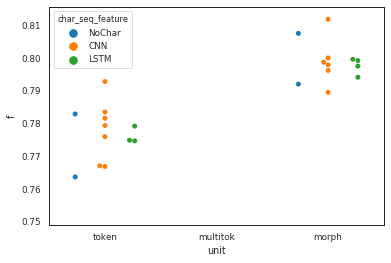

In [259]:
sns.swarmplot(data=erdf, x='unit', y='f', hue='char_seq_feature', dodge=True)


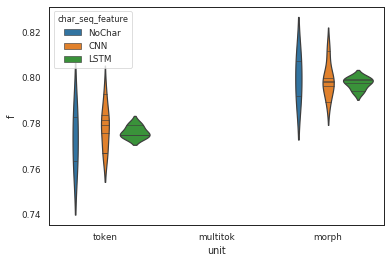

In [260]:
sns.violinplot(data=erdf, x='unit', y='f', hue='char_seq_feature', inner='stick')


## Learning rate

In [149]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).conf_num.nunique().unstack()

arch                     morph_charcnn  morph_charlstm  morph_nochar  \
optimizer learning_rate                                                
SGD       0.005                      7               4             2   
          0.010                     11               3             2   

arch                     multitok_charcnn  multitok_charlstm  multitok_nochar  \
optimizer learning_rate                                                         
SGD       0.005                         6                  4                2   
          0.010                        10                  4                2   

arch                     token_charcnn  token_charlstm  token_nochar  
optimizer learning_rate                                               
SGD       0.005                      8               4             2  
          0.010                      8               4             2

In [150]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).f.median().unstack()

arch                     morph_charcnn  morph_charlstm  morph_nochar  \
optimizer learning_rate                                                
SGD       0.005                 0.7832         0.79385         0.779   
          0.010                 0.7866         0.79090         0.780   

arch                     multitok_charcnn  multitok_charlstm  multitok_nochar  \
optimizer learning_rate                                                         
SGD       0.005                       NaN                NaN              NaN   
          0.010                       NaN                NaN              NaN   

arch                     token_charcnn  token_charlstm  token_nochar  
optimizer learning_rate                                               
SGD       0.005                0.76300         0.76480        0.7352  
          0.010                0.76615         0.77195        0.7431

In [151]:
erdf.groupby(['optimizer', 'learning_rate', 'arch']).f.max().unstack()

arch                     morph_charcnn  morph_charlstm  morph_nochar  \
optimizer learning_rate                                                
SGD       0.005                 0.7918          0.7974        0.7791   
          0.010                 0.7966          0.7918        0.7826   

arch                     multitok_charcnn  multitok_charlstm  multitok_nochar  \
optimizer learning_rate                                                         
SGD       0.005                       NaN                NaN              NaN   
          0.010                       NaN                NaN              NaN   

arch                     token_charcnn  token_charlstm  token_nochar  
optimizer learning_rate                                               
SGD       0.005                 0.7717          0.7676        0.7372  
          0.010                 0.7789          0.7749        0.7484

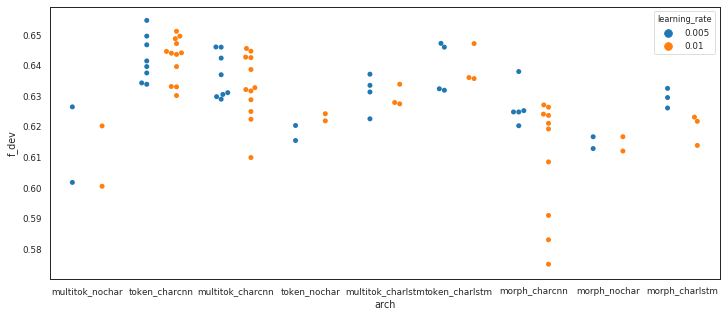

In [150]:
plt.figure(figsize=(12,5))
g = sns.swarmplot(data=erdf, hue='learning_rate', y='f_dev', x='arch', dodge=True)


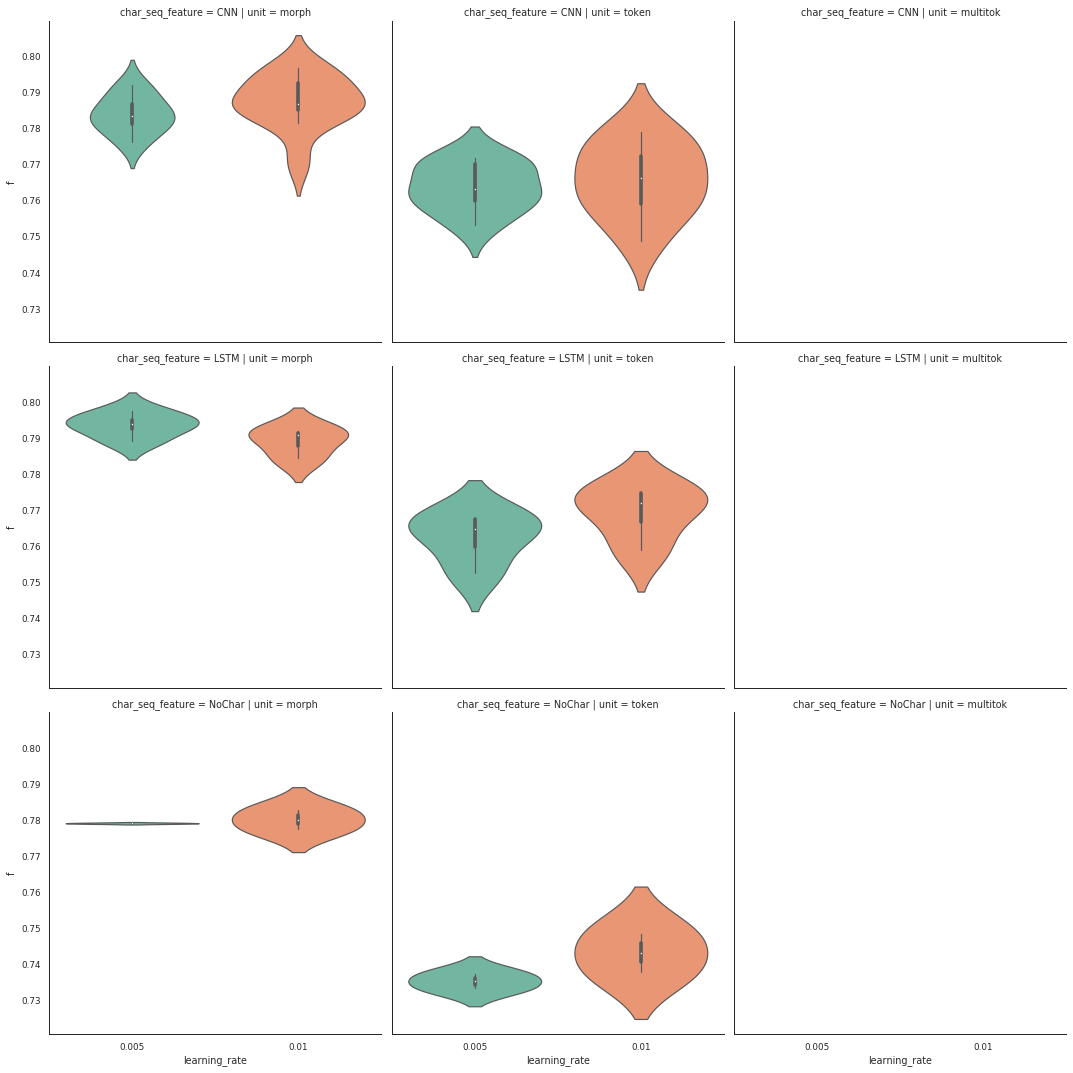

In [159]:
sns.catplot(kind='violin', row='char_seq_feature', col='unit', 
            x="learning_rate", y="f", #hue='batch_size',
                data=erdf, palette="Set2",
                scale="count", inner="box", scale_hue=True)

In [149]:
from scipy.stats import f_oneway

anov = {}
for a in erdf.arch.unique():
        anov[a] = f_oneway(erdf[(erdf.arch==a) & (erdf.learning_rate==0.005)].f_dev,
                             erdf[(erdf.arch==a) & (erdf.learning_rate==0.01)].f_dev,
                )
anov

{'multitok_nochar': F_onewayResult(statistic=0.05608341527447273, pvalue=0.8348430472184006),
 'token_charcnn': F_onewayResult(statistic=0.0028172657484623422, pvalue=0.9582544683769642),
 'multitok_charcnn': F_onewayResult(statistic=0.6191477750355167, pvalue=0.4416017633045809),
 'token_nochar': F_onewayResult(statistic=3.5662635791944997, pvalue=0.1995672763500052),
 'multitok_charlstm': F_onewayResult(statistic=0.11854933905649191, pvalue=0.7446216559129581),
 'token_charlstm': F_onewayResult(statistic=0.0021210050050691075, pvalue=0.9650497307123853),
 'morph_charcnn': F_onewayResult(statistic=3.3219489697985085, pvalue=0.0914345632535612),
 'morph_nochar': F_onewayResult(statistic=0.016598070404663257, pvalue=0.9092766397222409),
 'morph_charlstm': F_onewayResult(statistic=8.180728450037035, pvalue=0.045920340301535335)}

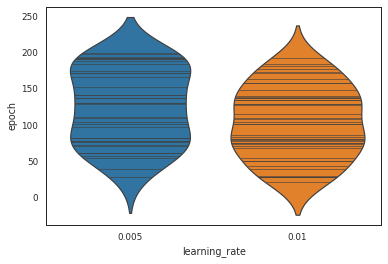

In [160]:
sns.violinplot(data=erdf, x='learning_rate', y='epoch', inner='stick')

### Do the lower scores in the lower learning rate come from lack of epochs?

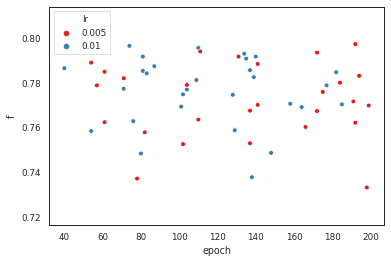

In [161]:
sns.scatterplot(data=erdf.assign(lr=lambda x: x.learning_rate.astype('str')), hue='lr', x='epoch', y='f',
               palette=sns.color_palette("Set1", erdf.learning_rate.nunique()))

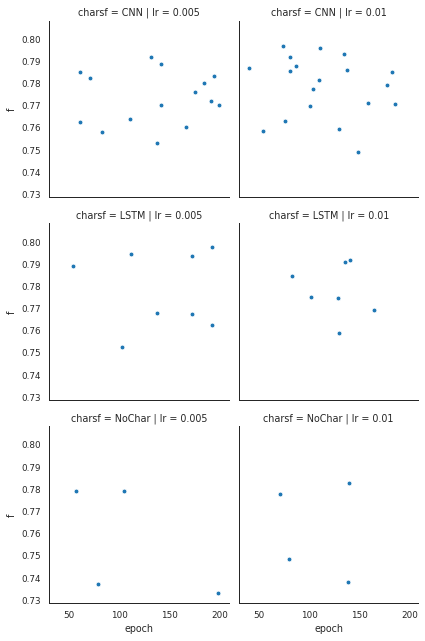

In [162]:
>>> g = sns.FacetGrid(erdf.rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col="lr", row='charsf')
>>> g = g.map(plt.scatter, "epoch", "f", edgecolor="w")

In [ ]:
>>> g = sns.FacetGrid(erdf[erdf.unit=='token'].rename(columns={'learning_rate': 'lr', 'char_seq_feature': 'charsf'}), col="lr", row='charsf')
>>> g = g.map(sns.kdeplot, "epoch", "f")

In [ ]:
>>> g = sns.FacetGrid(erdf.rename(columns={'char_seq_feature': 'charsf'}), col="batch_size", row='charsf')
>>> g = g.map(plt.scatter, "epoch", "f", edgecolor="w")

In [ ]:
>>> g = sns.FacetGrid(erdf.rename(columns={'char_seq_feature': 'charsf'}), col="batch_size", row='charsf')
>>> g = g.map(sns.kdeplot, "epoch", "f")

In [ ]:
sns.swarmplot(data=erdf, x='arch', y='epoch')

## Batch size

In [2425]:
erdf.groupby(['batch_size', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,morph_nochar,token_charcnn,token_charlstm,token_nochar
batch_size,,,,,,
1,0.78170,0.78515,0.7719,0.7476,0.75575,0.7290
8,0.77795,0.78130,0.7721,0.7478,0.75350,0.7306


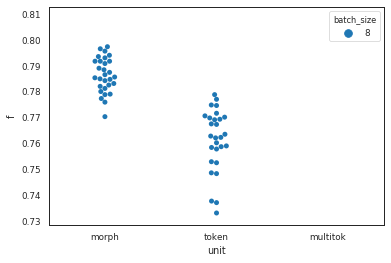

In [164]:
sns.swarmplot(data=erdf, x='unit', y='f', hue='batch_size', split=True)


In [165]:
sns.violinplot(data=erdf, x='unit', y='f', hue='batch_size', split=True, inner='stick')


ValueError: There must be exactly two hue levels to use `split`.'

## Char CNN window size

In [2428]:
erdf.groupby(['unit', 'char_kernel_size']).f.mean().unstack()

char_kernel_size,3.0,5.0,7.0
unit,,,
morph,0.774034,0.777962,0.781965
token,0.745823,0.746515,0.750941


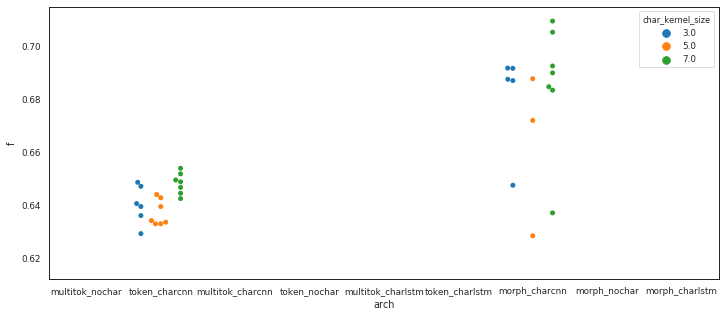

In [154]:
plt.figure(figsize=(12,5))
sns.swarmplot(data=erdf, x='arch', y='f', hue='char_kernel_size', dodge=True)


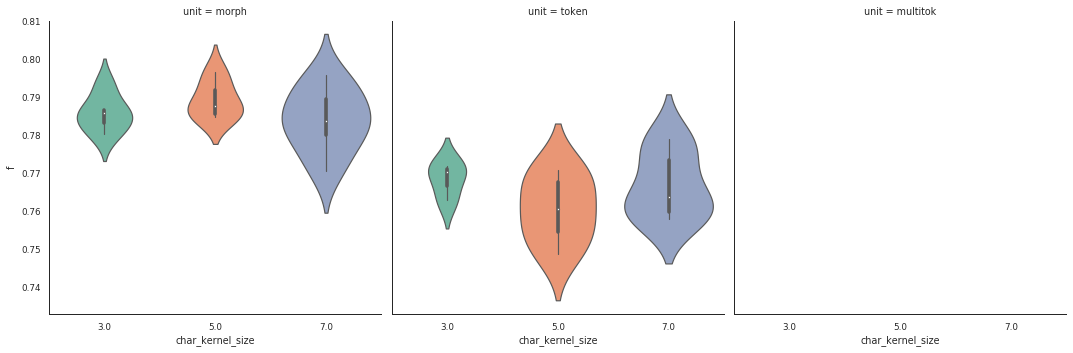

In [167]:
sns.catplot(kind='violin', col='unit', x="char_kernel_size", y="f",
                data=erdf, palette="Set2", 
                scale="count", inner="box")

## LSTM Layers stacked

In [2431]:
erdf.groupby(['lstm_layer', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,morph_nochar,token_charcnn,token_charlstm,token_nochar
lstm_layer,,,,,,
1,0.7772,0.7811,0.7751,0.74510,0.7519,0.72890
2,0.7809,0.7861,0.7719,0.75225,0.7594,0.73055


In [2432]:
erdf.groupby(['lstm_layer', 'arch']).f.max().unstack()

arch,morph_charcnn,morph_charlstm,morph_nochar,token_charcnn,token_charlstm,token_nochar
lstm_layer,,,,,,
1,0.7914,0.7966,0.7852,0.7666,0.7618,0.7424
2,0.7991,0.7974,0.7835,0.7749,0.7766,0.7476


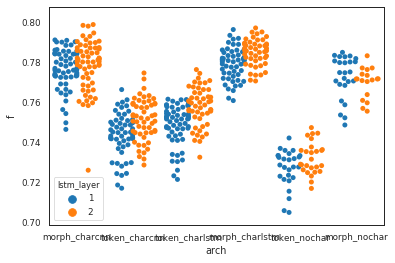

In [2433]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='lstm_layer', split=True)


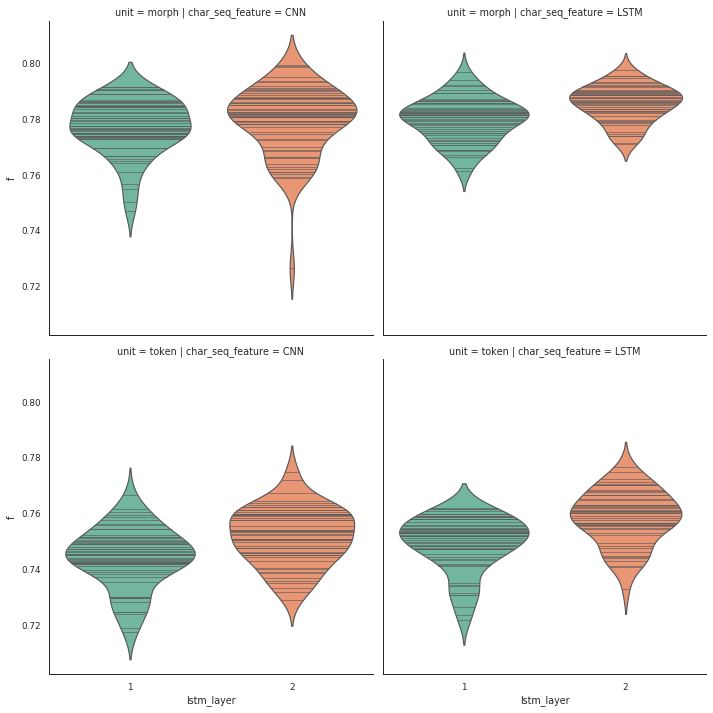

In [2434]:
sns.catplot(kind='violin', row='unit', col='char_seq_feature', 
            x="lstm_layer", y="f",
                data=erdf, palette="Set2", split=True,
                scale="count", inner="stick", scale_hue=True)

## Dropout

In [2435]:
erdf.groupby(['dropout', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,morph_nochar,token_charcnn,token_charlstm,token_nochar
dropout,,,,,,
0.4,0.7846,0.78210,0.7762,0.7524,0.7521,0.73045
0.5,0.7804,0.78345,0.7760,0.7492,0.7578,0.72930
0.6,0.7722,0.78090,0.7612,0.7422,0.7552,0.73020


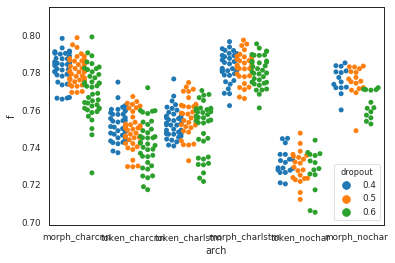

In [2436]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='dropout', split=True)


## Hidden dimensions

### WLSTM

In [2437]:
erdf.groupby(['hidden_dim', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,morph_nochar,token_charcnn,token_charlstm,token_nochar
hidden_dim,,,,,,
50,0.7742,0.77540,0.7706,0.7371,0.74410,0.72360
100,0.7850,0.78270,0.7754,0.7512,0.75765,0.73285
200,0.7817,0.78555,0.7774,0.7522,0.75715,0.73510


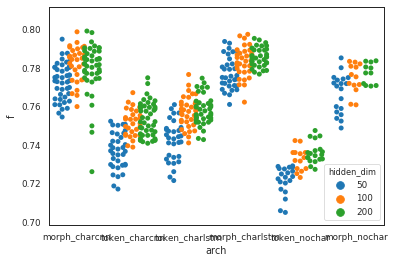

In [2438]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='hidden_dim', split=True)


### CLSTM / CCNN

In [2439]:
erdf.groupby(['char_hidden_dim', 'arch']).f.median().unstack()

arch,morph_charcnn,morph_charlstm,token_charcnn,token_charlstm
char_hidden_dim,,,,
50.0,0.7819,0.78395,0.7465,0.75485
70.0,0.7772,0.78200,0.7513,0.75190
90.0,0.7803,0.78220,0.7467,0.75600


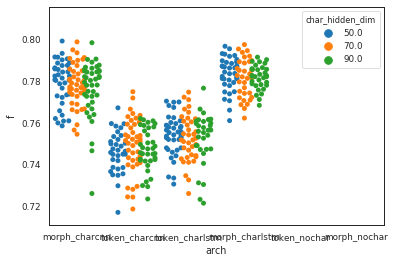

In [2440]:
sns.swarmplot(data=erdf, x='arch', y='f', hue='char_hidden_dim', split=True)

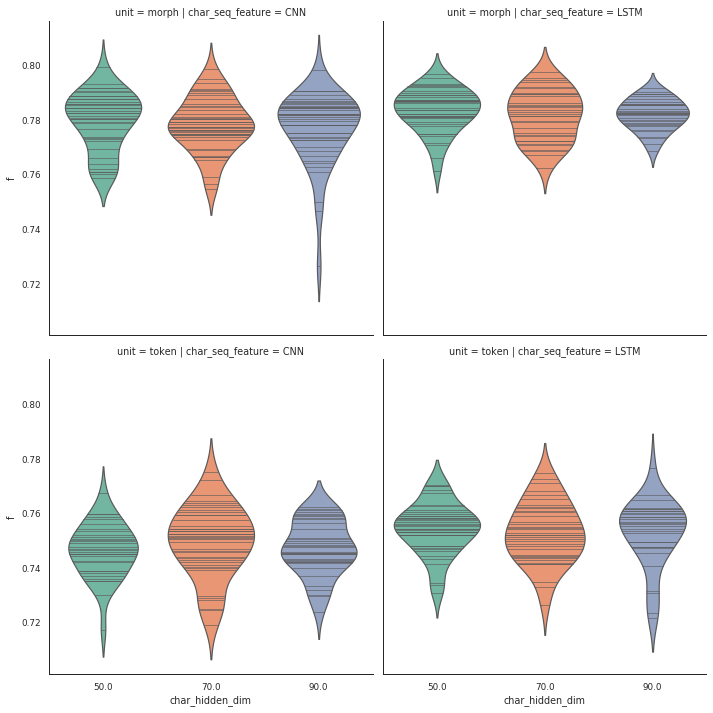

In [2441]:
sns.catplot(kind='violin', row='unit', col='char_seq_feature', 
            x="char_hidden_dim", y="f",
                data=erdf, palette="Set2", split=True,
                scale="count", inner="stick", scale_hue=True)

In [151]:
relevant_cols = ['arch', 'f_dev', 'char_hidden_dim', 'char_kernel_size', 'learning_rate']

In [152]:
erdf[relevant_cols].groupby('arch').apply(lambda x: x.sort_values('f_dev', ascending=False).head(2))

arch     f_dev  char_hidden_dim  \
arch                                                                 
morph_charcnn     69      morph_charcnn  0.637911             70.0   
                  47      morph_charcnn  0.627002             70.0   
morph_charlstm    35     morph_charlstm  0.632420             70.0   
                  16     morph_charlstm  0.629418             50.0   
morph_nochar      13       morph_nochar  0.616628              NaN   
                  67       morph_nochar  0.616610              NaN   
multitok_charcnn  86   multitok_charcnn  0.645949             50.0   
                  68   multitok_charcnn  0.645880             50.0   
multitok_charlstm 76  multitok_charlstm  0.637053             50.0   
                  56  multitok_charlstm  0.633772             50.0   
multitok_nochar   22    multitok_nochar  0.626374              NaN   
                  0     multitok_nochar  0.620155              NaN   
token_charcnn     1       token_charcnn  0.654628             50.0   
                  55      token_charcnn  0.651059             50.0   
token_charlstm    18     token_charlstm  0.647123             70.0   
                  71     token_charlstm  0.647059             70.0   
token_nochar      6        token_nochar  0.624130              NaN   
                  42       token_nochar  0.621810              NaN   

                      char_kernel_size  learning_rate  
arch                                                   
morph_charcnn     69               7.0          0.005  
                  47               3.0          0.010  
morph_charlstm    35               NaN          0.005  
                  16               NaN          0.005  
morph_nochar      13               NaN          0.010  
                  67               NaN          0.005  
multitok_charcnn  86               5.0          0.005  
                  68               3.0          0.005  
multitok_charlstm 76               NaN          0.005  
                  56               NaN          0.010  
multitok_nochar   22               NaN          0.005  
                  0                NaN          0.010  
token_charcnn     1                7.0          0.005  
                  55               7.0          0.010  
token_charlstm    18               NaN          0.005  
                  71               NaN          0.010  
token_nochar      6                NaN          0.010  
                  42               NaN          0.010

In [2443]:
rdf[rdf.groupby('arch').f.transform(max)==rdf.f].sort_values('f', ascending=False).T

,17957,13826,40290,9968,50194,44894
acc,0.97,0.9679,0.9666,0.9668,0.9655,0.9623
p,0.8558,0.8519,0.8612,0.8277,0.8424,0.8137
r,0.7495,0.7495,0.7214,0.7315,0.7174,0.6914
f,0.7991,0.7974,0.7852,0.7766,0.7749,0.7476
arch,morph_charcnn,morph_charlstm,morph_nochar,token_charlstm,token_charcnn,token_nochar
unit,morph,morph,morph,token,token,token
conf_num,017,011,071,017,075,014
word_seq_feature,LSTM,LSTM,LSTM,LSTM,LSTM,LSTM
word_emb_dim,300,300,300,300,300,300
char_emb_dim,30,30,30,30,30,30
